<a href="https://colab.research.google.com/github/paragajg/DSB8/blob/main/BTC-USDT%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ccxt mpl_finance

In [5]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpdates
import plotly.graph_objects as go
%matplotlib inline

In [153]:
class CCX:

  def __init__(self, xch, period = "1d"):
      # self.ticker = ticker
      self.xch = xch
      self.period = period
  
  def extractData(self, ticker):
    
    if self.xch != "binance":
      print("Unknown exchange . Program works only for Binance for now !!")
      return None

    exchange = ccxt.binance()
    if exchange.has['fetchOHLCV']:
      since = exchange.parse8601("2013-11-01T00:00:00Z")
      # print(since)

      all_orders = []
      while since < exchange.milliseconds():
          limit = 20  # change for your limit
          ohlcv = exchange.fetch_ohlcv(symbol = ticker, since = since, timeframe = self.period, limit = limit)
          if len(ohlcv) >0:
            # dt = (datetime.fromtimestamp(since) - timedelta(hours=2)).strftime('%Y-%m-%d %H:%M:%S')
            # print(f"Extracting data for date {dt}")
            since= ohlcv[len(ohlcv)-1][0] + 1
            all_orders += ohlcv
          else:
              break
  
    return all_orders

  def cleanData(self,ohlcv_list):
    temp = []
    for i in ohlcv_list:
      timestamp_with_ms = i[0]
      dt = datetime.datetime.fromtimestamp(timestamp_with_ms / 1000)
      formated_time = dt.strftime("%Y-%m-%d %H:%M%S.%f")[:-3]
      i[0] = dt
      temp.append(i)
    
    return temp

  def createDataFrame(self,ohlc_list):
    ohlcv_list = self.cleanData(ohlcv_list= ohlc_list)
    df = pd.DataFrame(ohlcv_list, columns= ["date", "o", "h", "l" , "c", "v"])
    print("DataFrame created")
    print(df.head())

    return df

In [154]:
cc = CCX(xch= "binance", period= "4h")

In [155]:
data = cc.extractData(ticker= "BTC/USDT")

In [156]:
len(data)

10340

In [157]:
df = cc.createDataFrame(ohlc_list= data)

DataFrame created
                 date        o        h        l        c           v
0 2017-08-17 04:00:00  4261.48  4349.99  4261.32  4349.99   82.088865
1 2017-08-17 08:00:00  4333.32  4485.39  4333.32  4427.30   63.619882
2 2017-08-17 12:00:00  4436.06  4485.39  4333.42  4352.34  174.562001
3 2017-08-17 16:00:00  4352.33  4354.84  4200.74  4325.23  225.109716
4 2017-08-17 20:00:00  4307.56  4369.69  4258.56  4285.08  249.769913


In [158]:
class PlotGraph:

  def __init__(self,df):
    self.df = df
    self.df['ewm200'] = df['c'].ewm(span=200,min_periods=0,adjust=False,ignore_na=False).mean()
    self.df['ewm50'] = df['c'].ewm(span=50,min_periods=0,adjust=False,ignore_na=False).mean()
    self.df['ewm20'] = df['c'].ewm(span=20,min_periods=0,adjust=False,ignore_na=False).mean()
  
  def createLineChart(self):
    plt.figure(figsize = (16,8))
    plt.plot(self.df.date,self.df.c, color = "black", label = "Closing Value")
    plt.plot(self.df.date, self.df["ewm200"] ,color = "teal", label = "EWMA 200")

    plt.title("Closing price of Bitcoin vs EMWA 200")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Bitcoin Price")
    plt.show()

    return None

  def createCandleStick(self):
    Df = self.df.copy()
    # apply map function
    try:
      Df['date'] = Df['date'].map(mpdates.date2num)
    except:
      pass

    # creating Subplots
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(8)
    
    # plotting the data
    candlestick_ohlc(ax, Df[["date","o","h","l","c"]].values, width=0.6, colorup='green', colordown='red', alpha=0.8)
    plt.plot(df.date, df["ewm200"] ,color = "teal", label = "EWMA 200")
    # allow grid
    # ax.grid(True)
    
    # Setting labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    
    # setting title
    plt.title('Bitcoin Candlesticks')
    
    # Formatting Date
    date_format = mpdates.DateFormatter('%d-%m-%Y')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    
    fig.tight_layout()
    
    # show the plot
    plt.show()

    return None
  
  def createInteractiveCS(self, ewm = "ewm200"):
    '''
    ewm = ["ewm200", "ewm50", "ewm20"]
    '''
    fig = go.Figure(data=[go.Candlestick(
    x=self.df['date'],
    open=self.df['o'], high= self.df['h'],
    low= self.df['l'], close= self.df['c'],
    increasing_line_color= 'green', decreasing_line_color= 'red')])

    fig.add_trace(go.Scatter(x= self.df["date"], y=df[ewm],
                        mode='lines',
                        name='EMA200',line=dict(color="teal")))

    fig.update_layout(
    title="CandleSticks for BTC/USDT",
    xaxis_title="Dates",
    yaxis_title="Price ($)",
    legend_title="CandleSticks and EWMA",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"),
    plot_bgcolor = "white",
    height=800,

        )

    fig.show()

    return None

In [159]:
pg = PlotGraph(df = df)

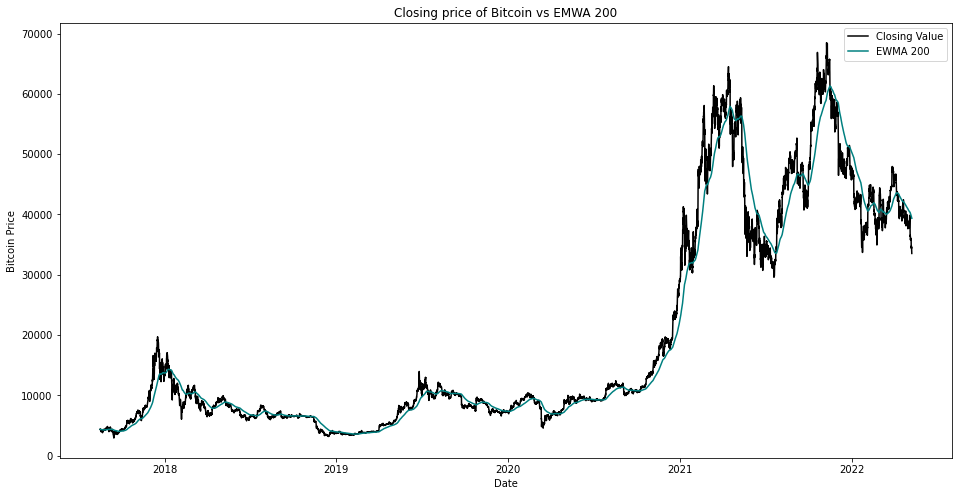

In [160]:
pg.createLineChart()

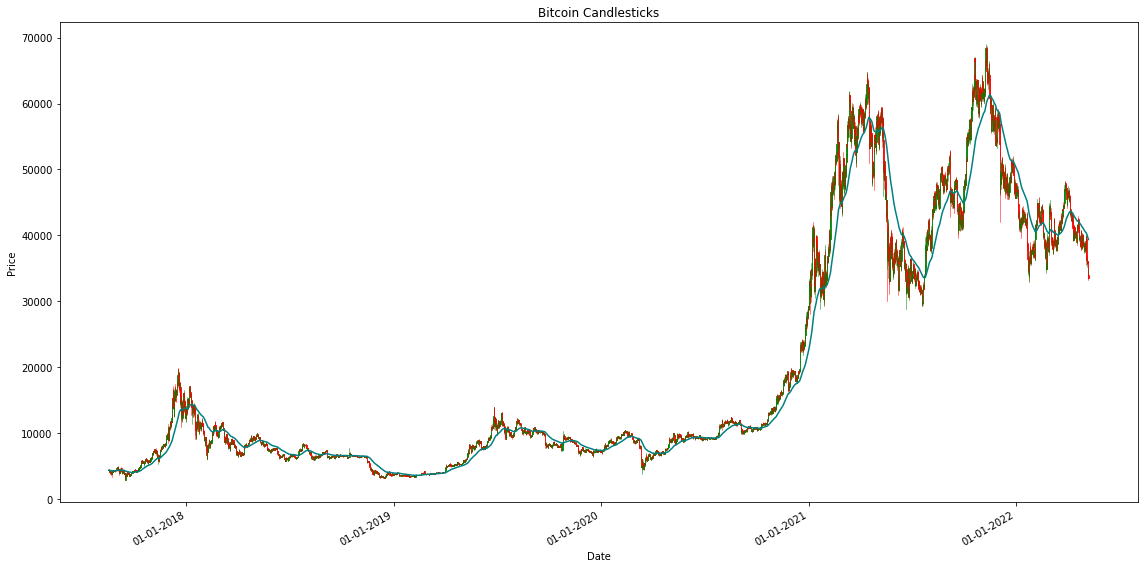

In [161]:
pg.createCandleStick()

In [17]:
pg.createInteractiveCS()

In [162]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [163]:
df["medianPrice"] = df[["o","h","l","c"]].apply(np.median,axis = 1)
df.head()

,date,o,h,l,c,v,ewm200,ewm50,ewm20,medianPrice
0,2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865,4349.990000,4349.990000,4349.990000,4305.735
1,2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882,4350.759254,4353.021765,4357.352857,4380.310
2,2017-08-17 12:00:00,4436.06,4485.39,4333.42,4352.34,174.562001,4350.774983,4352.995029,4356.875442,4394.200
3,2017-08-17 16:00:00,4352.33,4354.84,4200.74,4325.23,225.109716,4350.520804,4351.906204,4353.861591,4338.780
4,2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913,4349.869651,4349.285569,4347.310963,4296.320


In [172]:
def prepare_data(df,forecast_col,forecast_out,test_size):
    label = df[forecast_col].shift(-forecast_out)#creating new column called label with the last 5 rows are nan (Not a Number)
    print(f"Length of label column {label[20:]}")
    X = np.array(df[[forecast_col]]); #creating the feature array
    X = preprocessing.scale(X) #processing the feature array
    X_lately = X[-forecast_out:] #creating the column I want to use later in the predicting method
    X = X[:-forecast_out] # X that will contain the training and testing
    label.dropna(inplace=True); #dropping na values
    y = np.array(label)  # assigning Y
    
    # Create training and test data
    X_train = X[0:int(len(X)*(1-test_size))]
    X_test = X[-int(len(X)*test_size):]
    Y_train = y[0:int(len(y)*(1-test_size))]
    Y_test = y[-int(len(y)* test_size):]
    response = [X_train,X_test , Y_train, Y_test , X_lately]
    return response

In [173]:
def train_model(model_class,X_train,Y_train,X_test,Y_test,X_lately = None):
    learner = model_class
    learner.fit(X_train,Y_train); #training the model
    score=learner.score(X_test,Y_test);#testing model

    response={};#creating dictionary object
    response['test_score']=score
    
    if X_lately is not None:
      forecast= learner.predict(X_lately); #set that will contain the forecasted data
      response['forecast_set']=forecast
    
    print(response)

    return learner

In [174]:
df["medianPrice_trans"] = df["medianPrice"]
forecast_col = 'medianPrice'#choosing which column to forecast
forecast_out = 4 #how far to forecast 
test_size = 0.2#the size of my test set

X_train, X_test, Y_train, Y_test , X_lately = prepare_data(df,forecast_col,forecast_out,test_size)

Length of label column 20        4061.445
21        4033.370
22        4022.555
23        4016.520
24        4021.525
           ...    
10335    33547.500
10336          NaN
10337          NaN
10338          NaN
10339          NaN
Name: medianPrice, Length: 10320, dtype: float64


In [175]:
learner = train_model(model_class = LinearRegression(),X_train = X_train,
                      Y_train = Y_train ,X_test = X_test,Y_test = Y_test,X_lately = X_lately)

{'test_score': 0.9798233155888959, 'forecast_set': array([34474.9829829 , 34315.32360921, 33803.38023231, 33550.26183492])}


In [180]:
def plot_prices(df, n_freq = 7):
  fig = go.Figure()

  fig.add_trace(go.Scatter(x=df["date"], y=df["medianPrice"],
                      mode='lines',
                      name='Price',line=dict(color="teal")))
  # plt.plot(df.Date[-len(X_test):], learner.predict(X_test), color='blue', linewidth=1, label = 'Predicted Price') #plotting the line made by linear regression
  fig.add_trace(go.Scatter(x = df.date[-len(X_test):], y = learner.predict(X_test),
                          mode = 'lines', name = "Predicted Price", line = dict(color = "blue")))

  fig.add_trace(go.Scatter(x = pd.date_range(df[-1:]["date"].values[0], periods= n_freq),
                           y = learner.predict(X_lately),
                          mode = 'lines', name = "Forecasted Price", line = dict(color = "red")))

  fig.update_layout(title = "Brent Oil Prediction & Forecasting over 10 days in future",
                    plot_bgcolor='black',
                  xaxis=dict(showgrid=False),yaxis=dict(showgrid=False),
                  xaxis_title='Date',
                    yaxis_title='Brent Oil Prices ($)')

  fig.show()

In [182]:
plot_prices(df, n_freq= 100)

In [183]:
len(df), df.shape

(10340, (10340, 11))

In [184]:
def preprocess_data(df,scaling = True,n_features = 7):
  if scaling:
    scale = StandardScaler()
    df["medianPrice"] = scale.fit_transform(df["medianPrice"].values.reshape(-1, 1))
  
  y = [] 
  for i in range(len(df)):
    try:
      y.append(df.loc[i+ n_features,"medianPrice"])
    except:
      pass
  print(f"total Y: {len(y)}")
  print(f"*"*40)
  print(y[-10:])

  features_grouped = []
  for i in range(len(df)):
    try:
      temp = list(df.loc[i: (i+ n_features)-1, "medianPrice"])
      # print(f"Type: {type(temp)}")
      features_grouped.append(temp)
    except:
      pass

  features_grouped = [list(x) for x in features_grouped]
  features_grouped = features_grouped[:len(y)]

  print(f"total Xs: {len(features_grouped)}")
  print(f"*"*40)
  print(features_grouped[-1:])

  if scaling:
    return features_grouped, y, scale
  else:
    return features_grouped, y

In [185]:
features_grouped, y = preprocess_data(df = df, scaling= False, n_features = 200)

total Y: 10140
****************************************
[35919.415, 35674.380000000005, 34976.32, 34538.39, 34691.395000000004, 34572.085, 34472.775, 34313.020000000004, 33800.770000000004, 33547.5]
total Xs: 10140
****************************************
[[45765.020000000004, 45356.71, 45245.96, 45047.615000000005, 44493.770000000004, 43961.465, 43462.515, 43232.255000000005, 43369.685, 43606.03999999999, 43549.28, 43360.369999999995, 43416.56, 43525.08, 43684.735, 43531.16, 43473.4, 43189.425, 42491.425, 42316.009999999995, 42430.545, 42463.09, 42352.92999999999, 42382.479999999996, 42632.96, 42769.84, 42709.655, 42656.975, 42713.91, 42991.625, 42697.31, 42135.035, 42208.479999999996, 41686.685, 40824.575, 40283.425, 39757.895, 39638.78999999999, 39965.555, 40280.985, 40278.565, 39741.11, 39689.020000000004, 40075.5, 40103.025, 39926.315, 40440.405, 41108.740000000005, 41103.55, 41233.89, 41295.83, 41095.825, 40442.005, 39869.915, 39859.095, 40071.655, 40220.19, 40229.715, 40316.1, 4

In [186]:
def create_data(X,y, test_size = 0.1):
  # Create training and test data
      X_train = np.array(X[0:int(len(X)*(1-test_size))])
      X_test = np.array(X[-int(len(X)*test_size):])
      Y_train = np.array(y[0:int(len(y)*(1-test_size))]).reshape(-1, 1)
      Y_test = np.array(y[-int(len(y)* test_size):]).reshape(-1, 1)
      response = [X_train,X_test , Y_train, Y_test]

      return response

In [187]:
X_train,X_test , Y_train, Y_test = create_data(X = features_grouped, y = y, test_size= 0.01 )

print('Shape of Training Xs:{}'.format(X_train.shape))
print('Shape of Test Xs:{}'.format(X_test.shape))
print('Shape of Training y:{}'.format(Y_train.shape))
print('Shape of Test y:{}'.format(Y_test.shape))

Shape of Training Xs:(10038, 200)
Shape of Test Xs:(101, 200)
Shape of Training y:(10038, 1)
Shape of Test y:(101, 1)


In [188]:
learner = train_model(model_class = LinearRegression(),X_train = X_train,
                      Y_train = Y_train ,X_test = X_test,Y_test = Y_test)

{'test_score': 0.9763041134138782}


In [189]:
y_predicted = learner.predict(X_test)
# y_predicted = scale.inverse_transform(y_predicted_scaled)
y_predicted = y_predicted.flatten()
print(f"Predicted daily median prices: {y_predicted[-5:]}")
print(f"Total predictions for past: {len(y_predicted)}")

Predicted daily median prices: [34831.80146079 34413.61543514 34628.97053876 34032.49834941
 33528.87230573]
Total predictions for past: 101


In [190]:
def plot_predictions(df,y_predicted):
  fig = go.Figure()

  fig.add_trace(go.Scatter(x=df["date"], y=df["medianPrice"],
                      mode='lines',
                      name='Median Price',line=dict(color="teal")))
  # plt.plot(df.Date[-len(X_test):], learner.predict(X_test), color='blue', linewidth=1, label = 'Predicted Price') #plotting the line made by linear regression
  fig.add_trace(go.Scatter(x = df.date[-len(y_predicted):], y = y_predicted,
                          mode = 'lines', name = "Predicted Median Price", line = dict(color = "blue")))

  #, 
  # fig.add_trace(go.Scatter(x = pd.date_range('2021-01-26', '2021-02-08', freq= pd.tseries.offsets.BDay()),
  #                          y = learner.predict(X_lately),
  #                         mode = 'lines', name = "Forecasted Price", line = dict(color = "red")))

  fig.update_layout(title = "BTC/USDT Prediction",
                    plot_bgcolor='black',
                  xaxis=dict(showgrid=False),yaxis=dict(showgrid=False),
                  xaxis_title='Date',
                    yaxis_title='Prices ($)')

  fig.show()

In [191]:
plot_predictions(df,y_predicted)

In [192]:
def forecast_price(model,df,n_future = 7):
  x_forecast = df[- n_future:]["medianPrice"].tolist()
  temp_forecasting = []
  for i in range(n_future):
    x = [x_forecast[i:i+n_future]]
    # print(f"Input Xs: {x}")
    temp_prediction = model.predict(x).flatten()[0]
    # print(f"Prediction for next event: {temp_prediction}")
    temp_forecasting.append(temp_prediction)
    x_forecast.append(temp_prediction)
  
  return  x_forecast, temp_forecasting


In [193]:
x_forecast, temp_prediction = forecast_price(model = learner, df = df, n_future = 200)

In [203]:
forecasting_days = 100
current_Date = df[-1:]["date"].values[0]
forecasting_date_range = pd.date_range(current_Date, periods= forecasting_days, freq="240min")
forecasting_date_range[0:10]

DatetimeIndex(['2022-05-09 04:00:00', '2022-05-09 08:00:00',
               '2022-05-09 12:00:00', '2022-05-09 16:00:00',
               '2022-05-09 20:00:00', '2022-05-10 00:00:00',
               '2022-05-10 04:00:00', '2022-05-10 08:00:00',
               '2022-05-10 12:00:00', '2022-05-10 16:00:00'],
              dtype='datetime64[ns]', freq='240T')

In [204]:
df.tail()

,date,o,h,l,c,v,ewm200,ewm50,ewm20,medianPrice,medianPrice_trans
10335,2022-05-08 12:00:00,34786.25,34843.01,34301.01,34357.92,9249.33238,39583.851786,37186.939975,35956.531542,34572.085,34572.085
10336,2022-05-08 16:00:00,34357.91,34763.34,33713.95,34587.64,17646.96381,39534.138236,37085.006642,35826.160919,34472.775,34472.775
10337,2022-05-08 20:00:00,34587.64,34640.00,33930.00,34038.40,8191.14427,39479.454273,36965.531872,35655.897974,34313.020,34313.020
10338,2022-05-09 00:00:00,34038.39,34243.15,33267.26,33563.15,22777.90390,39420.585574,36832.105132,35456.588644,33800.770,33800.770
10339,2022-05-09 04:00:00,33563.15,33838.42,33520.57,33531.85,2926.43723,39361.991190,36702.683362,35273.280201,33547.500,33547.500


In [205]:
def plot_forecasting(df,y_predicted,forecast_values, forecast_days):
  fig = go.Figure()

  fig.add_trace(go.Scatter(x=df["date"], y=df["medianPrice"],
                      mode='lines',
                      name='Price',line=dict(color="teal")))
  # plt.plot(df.Date[-len(X_test):], learner.predict(X_test), color='blue', linewidth=1, label = 'Predicted Price') #plotting the line made by linear regression
  fig.add_trace(go.Scatter(x = df.date[-len(y_predicted):], y = y_predicted,
                          mode = 'lines', name = "Predicted Price", line = dict(color = "blue")))

  fig.add_trace(go.Scatter(x = forecast_days,
                           y = forecast_values,
                          mode = 'lines', name = "Forecasted Price", line = dict(color = "red")))

  fig.update_layout(title = f"BTC/USDT Daily Median Price Prediction & Forecasted Values over next {len(forecast_days)} days",
                    plot_bgcolor='black',
                  xaxis=dict(showgrid=False),yaxis=dict(showgrid=False),
                  xaxis_title='Date',
                    yaxis_title='Prediction Prices ($)')

  fig.show()

In [206]:
plot_forecasting(df,y_predicted,forecast_values = temp_prediction, forecast_days = forecasting_date_range)